In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input, concatenate,Lambda,GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
env=gym.make("Pendulum-v0")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

In [5]:
        

class DDPG(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.update_weights(self.target_actor,self.actor)
        
        
        self.critic=self.Critic(paras)
        self.target_critic=self.Critic(paras,Target=True)
        self.update_weights(self.target_critic,self.critic)
        
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.polyak=paras['polyak']
        self.count=0
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            sigma=self.sigma
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_weights(self,update_target,update_source,polyak=0):
        old_weight=update_target.get_weights()
        new_weight=update_source.get_weights()
        weight=[polyak*old_weight[idx]+(1-polyak)*new_weight[idx] for idx in range(len(new_weight))]
        update_target.set_weights(weight)
        
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        Q_sp_ap=self.target_critic.predict([sp,mup])
        target=r+self.gamma*Q_sp_ap*(1-done)
        self.critic.fit([s,a],target,verbose=False) 
        
        mu=self.actor.predict(s)
        d_mu=self.get_grad([s,mu])[0]
        self.actor.fit(s,mu+d_mu,verbose=False) 
        
        self.update_weights(self.target_actor,self.actor,self.polyak)
        self.update_weights(self.target_critic,self.critic,self.polyak)

1 -1495.4602055106793 [4.] 200
2 -1088.2193100943348 [4.] 400
3 -1486.681263509016 [4.] 600
4 -1427.5957084450115 [4.] 800
5 -1366.5519086177437 [4.] 1000
6 -1486.8013930001566 [4.] 1200
7 -1081.0404628844556 [4.] 1400
8 -1535.4911595775663 [4.] 1600
9 -1437.978007931368 [4.] 1800
10 -1485.657613132611 [4.] 2000
10 -1389.1477032702944


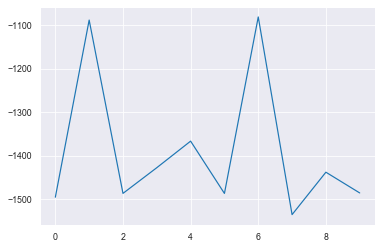

11 -1496.3362979201954 [4.] 2200
12 -1577.2034896731905 [4.] 2400
13 -1155.1269952610778 [4.] 2600
14 -1331.8859205866736 [4.] 2800
15 -1522.3349351252614 [4.] 3000
16 -1188.5726348538922 [4.] 3200
17 -1537.954050460873 [4.] 3400
18 -1500.3820010981185 [4.] 3600
19 -1484.6115350451464 [4.] 3800
20 -1517.8796930817507 [4.] 4000
20 -1410.188229290456


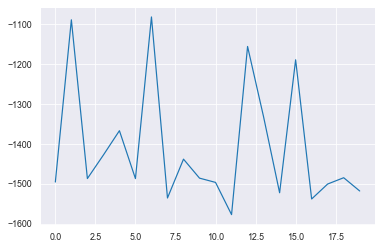

21 -1488.449863492676 [4.] 4200
22 -1352.3547182230943 [4.] 4400
23 -1511.1010631224538 [4.] 4600
24 -1493.5747359331688 [4.] 4800
25 -1585.1713088460158 [4.] 5000
26 -1486.116319524431 [4.] 5200
27 -1437.1396676601762 [4.] 5400
28 -1536.5395453995247 [4.] 5600
29 -1452.1309410829492 [4.] 5800
30 -1108.723134553346 [4.] 6000
30 -1421.8355294548987


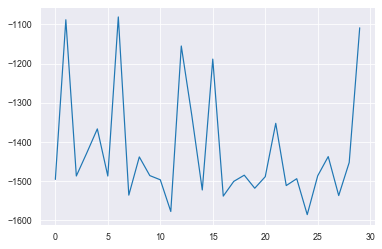

31 -1241.8891506831624 [4.] 6200
32 -1179.8615158747823 [4.] 6400
33 -1520.1079806239095 [4.] 6600
34 -1511.5597435979832 [4.] 6800
35 -941.2315601836242 [4.] 7000
36 -1500.5481993680053 [4.] 7200
37 -1411.4388605476368 [4.] 7400
38 -1343.557617722691 [4.] 7600
39 -1295.6045305401824 [4.] 7800
40 -1209.2866523873624 [4.] 8000
40 -1395.2537923794075


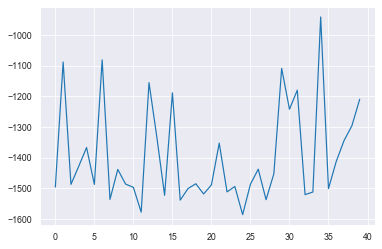

41 -1353.1568387588877 [4.] 8200
42 -1472.534879823877 [4.] 8400
43 -1240.9531062451902 [4.] 8600
44 -1341.044522908957 [4.] 8800
45 -1523.2128077480502 [4.] 9000
46 -1049.4594062967349 [4.] 9200
47 -1381.8819742552541 [4.] 9400
48 -1178.8717252539973 [4.] 9600
49 -1175.086342283586 [4.] 9800
50 -1562.1047687208263 [3.996] 10000
50 -1381.7691613494328


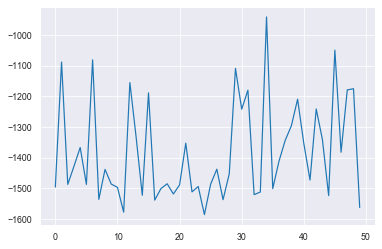

51 -1256.6326156500588 [3.2713287] 10200
52 -1342.5267794857762 [2.6780767] 10400
53 -1293.8518817291567 [2.1924098] 10600
54 -1448.0385294203465 [1.7948194] 10800
55 -1357.474146320147 [1.4693302] 11000
56 -1353.54714958166 [1.202869] 11200
57 -1499.9673099797842 [0.98472947] 11400
58 -1307.8786506686572 [0.80614966] 11600
59 -1404.6760292353108 [0.65995526] 11800
60 -1311.0150799404184 [0.5402731] 12000
60 -1375.451784135601


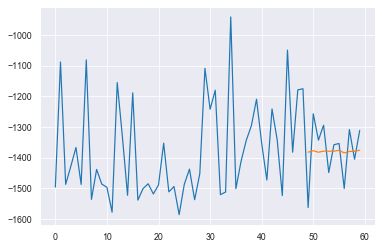

61 -1213.6493349372984 [0.44229522] 12200
62 -1185.7845361699392 [0.36208537] 12400
63 -905.8085946337122 [0.29642162] 12600
64 -1540.1275168320744 [0.24266596] 12800
65 -619.7860119987289 [0.19865876] 13000
66 -1186.3109789797502 [0.1626322] 13200
67 -492.9246584860688 [0.13313898] 13400
68 -1507.911043667947 [0.1089944] 13600
69 -1369.7951115182746 [0.08922836] 13800
70 -1284.3326092424531 [0.07304686] 14000
70 -1315.3346410028018


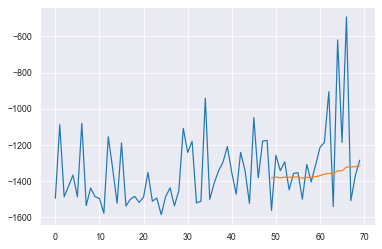

71 -785.1073086197609 [0.05979986] 14200
72 -1145.7432442128136 [0.04895522] 14400
73 -941.0168425495216 [0.04007723] 14600
74 -985.1161956091864 [0.03280927] 14800
75 -1062.1512572237027 [0.02685933] 15000
76 -1136.1634338398717 [0.02198842] 15200
77 -948.1402414814314 [0.01800085] 15400
78 -664.4112944494759 [0.01473642] 15600
79 -950.9782575132889 [0.01206399] 15800
80 -845.5664148313191 [0.0098762] 16000
80 -1215.596504852653


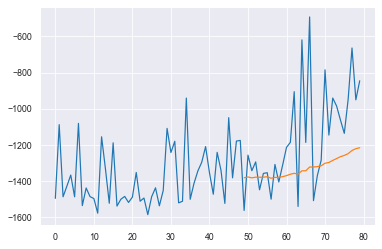

81 -1019.4569475779458 [0.00808515] 16200
82 -838.0177025675931 [0.00661892] 16400
83 -1189.3234990319866 [0.00541858] 16600
84 -1161.9719312071495 [0.00443593] 16800
85 -918.1242946923189 [0.00363148] 17000
86 -1492.2787211767468 [0.00297291] 17200
87 -1026.20387428847 [0.00243378] 17400
88 -1521.5697607543507 [0.00199241] 17600
89 -1339.0466355996366 [0.00163109] 17800
90 -938.2669464801828 [0.00133529] 18000
90 -1181.3799948895935


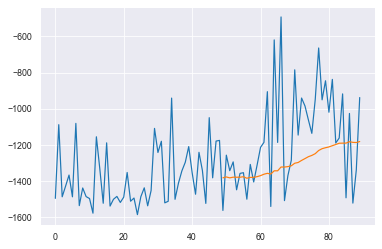

91 -1221.5511701064836 [0.00109314] 18200
92 -1026.938095608142 [0.0008949] 18400
93 -1085.1276604166976 [0.00073261] 18600
94 -1172.1662447388103 [0.00059975] 18800
95 -1007.2002521662571 [0.00049099] 19000
96 -911.0945918395041 [0.00040195] 19200
97 -734.1801085178573 [0.00032905] 19400
98 -1176.5378997012037 [0.00026938] 19600
99 -1035.1929032722046 [0.00022053] 19800
100 -664.77986125617 [0.00018054] 20000
100 -1116.509243196153


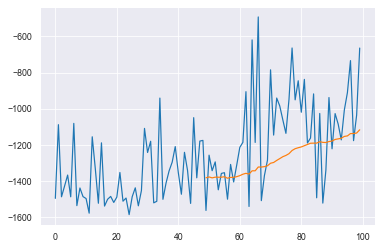

101 -1280.8663487531144 [0.0001478] 20200
102 -672.4232762330372 [0.00012099] 20400
103 -912.739987842826 [9.905144e-05] 20600
104 -1182.6153165300643 [8.1088576e-05] 20800
105 -1156.6606931240574 [6.638322e-05] 21000
106 -865.2848334516709 [5.434466e-05] 21200
107 -629.3918346397923 [4.448929e-05] 21400
108 -637.927315096531 [3.642119e-05] 21600
109 -872.6638567787544 [2.981625e-05] 21800
110 -882.7754328583501 [2.4409093e-05] 22000
110 -1026.8640576620905


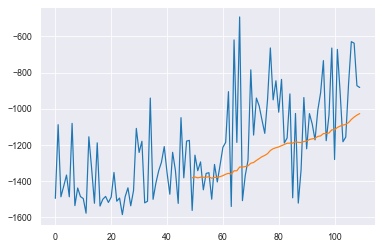

111 -873.0069814385814 [1.9982537e-05] 22200
112 -868.3782246786554 [1.6358732e-05] 22400
113 -3.140158895007001 [1.3392086e-05] 22600
114 -133.7842012272465 [1.0963444e-05] 22800
115 -344.27195170660207 [1.e-05] 23000
116 -2.6993187378416605 [1.e-05] 23200
117 -363.9529992924254 [1.e-05] 23400
118 -127.68671950520499 [1.e-05] 23600
119 -249.64210643867457 [1.e-05] 23800
120 -270.03632776703296 [1.e-05] 24000
120 -865.467429526511


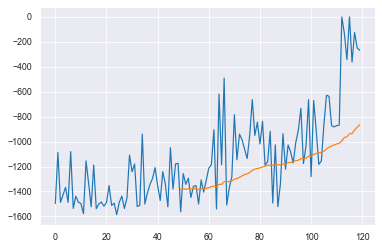

121 -5.7374352834860805 [1.e-05] 24200
122 -363.5953633708774 [1.e-05] 24400
123 -247.51154355175422 [1.e-05] 24600
124 -356.7107342853557 [1.e-05] 24800
125 -537.715558628262 [1.e-05] 25000
126 -494.99854467775106 [1.e-05] 25200
127 -258.52416646227954 [1.e-05] 25400
128 -267.57933756586095 [1.e-05] 25600
129 -233.09612645263923 [1.e-05] 25800
130 -121.09741698856527 [1.e-05] 26000
130 -733.9108642652404


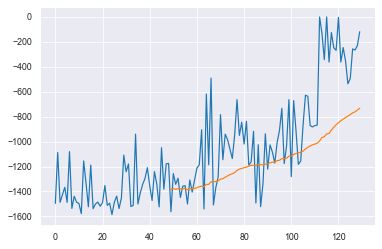

131 -344.86278668725214 [1.e-05] 26200
132 -353.8735991521193 [1.e-05] 26400
133 -390.4435326828978 [1.e-05] 26600
134 -389.09559718115673 [1.e-05] 26800
135 -230.23496543502628 [1.e-05] 27000
136 -254.58431896927888 [1.e-05] 27200
137 -498.0419999264047 [1.e-05] 27400
138 -131.0799657129949 [1.e-05] 27600
139 -255.3790576775879 [1.e-05] 27800
140 -131.26435222590035 [1.e-05] 28000
140 -564.602861510725


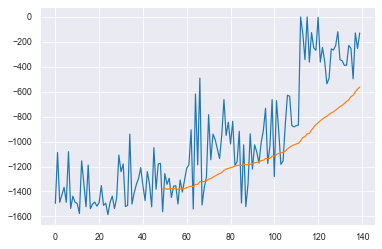

141 -129.68366386716238 [1.e-05] 28200
142 -308.50635743721466 [1.e-05] 28400
143 -134.97393177259275 [1.e-05] 28600
144 -264.47015402500796 [1.e-05] 28800
145 -254.3291048899613 [1.e-05] 29000
146 -250.71112544038547 [1.e-05] 29200
147 -122.83280998960579 [1.e-05] 29400
148 -128.31413809767932 [1.e-05] 29600
149 -336.1400587058962 [1.e-05] 29800
150 -13.946432748548313 [1.e-05] 30000
150 -402.7856412977395


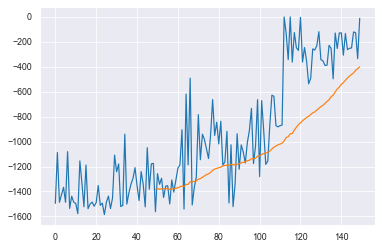

151 -364.30931734343284 [1.e-05] 30200
152 -118.92956856562091 [1.e-05] 30400
153 -123.15471363947587 [1.e-05] 30600
154 -270.2555903009569 [1.e-05] 30800
155 -444.50633821639525 [1.e-05] 31000
156 -137.68049514002604 [1.e-05] 31200
157 -136.93621570537823 [1.e-05] 31400
158 -131.317190388988 [1.e-05] 31600
159 -128.7008679790028 [1.e-05] 31800
160 -131.39787372922532 [1.e-05] 32000
160 -260.6624268117456


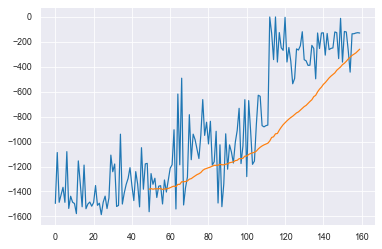

161 -244.05391817408469 [1.e-05] 32200
162 -136.3751249723903 [1.e-05] 32400
163 -130.56447438517247 [1.e-05] 32600
164 -249.32099258440897 [1.e-05] 32800
165 -128.56423093256933 [1.e-05] 33000
166 -293.4352106953624 [1.e-05] 33200
167 -241.33189809896896 [1.e-05] 33400
168 -128.6710788183476 [1.e-05] 33600
169 -130.54311864120987 [1.e-05] 33800
170 -300.1658766081022 [1.e-05] 34000
170 -235.59096549621245


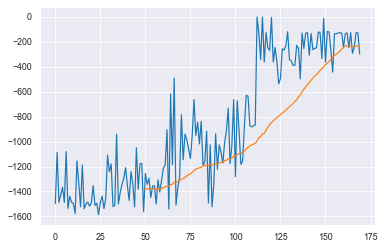

171 -139.18750925310965 [1.e-05] 34200
172 -263.8537139636604 [1.e-05] 34400
173 -135.57227086036423 [1.e-05] 34600
174 -18.493506228425133 [1.e-05] 34800
175 -143.1529689711811 [1.e-05] 35000
176 -136.36399196231633 [1.e-05] 35200
177 -142.014909733465 [1.e-05] 35400
178 -260.0804483426312 [1.e-05] 35600
179 -136.7440986612763 [1.e-05] 35800
180 -129.26157743693932 [1.e-05] 36000
180 -207.95414085914322


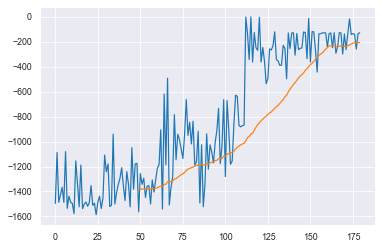

181 -499.5239624159161 [1.e-05] 36200
182 -137.49350102459726 [1.e-05] 36400
183 -133.44482359975038 [1.e-05] 36600
184 -133.29232442651485 [1.e-05] 36800
185 -139.2042249944374 [1.e-05] 37000
186 -347.14656070514366 [1.e-05] 37200
187 -136.1359032273964 [1.e-05] 37400
188 -126.77597469709376 [1.e-05] 37600
189 -132.83339226396163 [1.e-05] 37800
190 -128.83838320028823 [1.e-05] 38000
190 -186.6707183572328


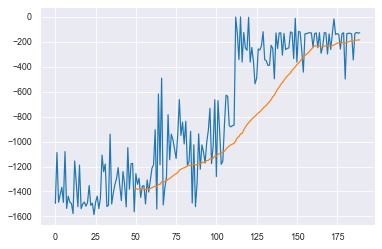

191 -131.90717766590447 [1.e-05] 38200
192 -12.34501573665926 [1.e-05] 38400
193 -128.85802614907527 [1.e-05] 38600
194 -9.176113009693989 [1.e-05] 38800
195 -8.831552873921758 [1.e-05] 39000
196 -126.35222623442647 [1.e-05] 39200
197 -128.16400057663685 [1.e-05] 39400
198 -230.03808648061676 [1.e-05] 39600
199 -121.62937287661339 [1.e-05] 39800
200 -120.22460398013598 [1.e-05] 40000
200 -168.14308632942547


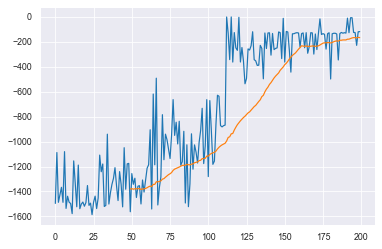

In [6]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000

agent=DDPG(agent_config)

Iter=200
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  